# Feature Engineering
In this notebook, we will try to create new variables and transformations based on the tests we have done in the EDA notebook.
We took into account the distributions of the various variables and whether they are consecutive or not.


In [2]:
##Importing required packages 
if(!require(DBI)){install.packages("DBI"); require(DBI)}
if(!require(RSQLite)){install.packages("RSQLite"); require(RSQLite)}
if(!require(dplyr)){install.packages("dplyr"); require(dplyr)}
if(!require(funModeling)){install.packages("funModeling"); require(funModeling)}

Loading required package: DBI
Loading required package: RSQLite
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: funModeling
Warning message:
"package 'funModeling' was built under R version 3.5.2"Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

funModeling v.1.6.8 :)
Examples and tutorials at livebook.datascienceheroes.com



In [3]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################
            

#### Read function to import data from the SQL to a pandas dataframe.
readSQL <- function(query, db=DB_FILE) {
    require(DBI)
    require(RSQLite)
    con <- dbConnect(SQLite(), DB_FILE)
    df <- dbGetQuery(con, query)
    return(df)
}

#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
writeSQL <- function(df,tablename,overwrite=FALSE, append=FALSE,db=DB_FILE) {
    require(DBI)
    require(RSQLite)
    con <- dbConnect(SQLite(), DB_FILE)
    dbWriteTable(con,tablename,df,overwrite,append)
}
####

In [4]:
DB_FILE = paste0(getwd(),"/Data/loans.db")

In [8]:
loans = readSQL("SELECT * FROM loans_dataset")

In [9]:
#make a copy - for restore if necessary 
loansdata <- loans

In [10]:
dim(loans)

[1] 255720     48

Sorting the parameters by their type

In [11]:
split(names(loans),sapply(loans, function(x) paste(class(x), collapse=" ")))

$character
[1] "verification_status" "issue_d"             "purpose"            
[4] "emp_length"          "home_ownership"      "full_state"         

$integer
 [1] "pymnt_plan"                  "initial_list_status"        
 [3] "loan_amnt"                   "funded_amnt"                
 [5] "term"                        "collections_12_mths_ex_med" 
 [7] "mths_since_last_major_derog" "delinq_2yrs"                
 [9] "acc_now_delinq"              "inq_last_6mths"             
[11] "mths_since_last_delinq"      "mths_since_last_record"     
[13] "open_acc"                    "pub_rec"                    
[15] "total_acc"                   "tot_coll_amt"               
[17] "open_acc_6m"                 "open_il_6m"                 
[19] "open_il_12m"                 "open_il_24m"                
[21] "mths_since_rcnt_il"          "total_bal_il"               
[23] "open_rv_12m"                 "open_rv_24m"                
[25] "max_bal_bc"                  "inq_fi"                     
[27] "total_cu_tl"                 "inq_last_12m"               
[29] "default"                     "credit_hist"                

$numeric
 [1] "funded_amnt_inv"  "annual_inc"       "dti"              "revol_bal"       
 [5] "revol_util"       "tot_cur_bal"      "il_util"          "all_util"        
 [9] "total_rev_hi_lim" "loan_installment" "acc_ratio"        "poverty_rate_p"

In [12]:
loans$verification_status <-as.factor(loans$verification_status)
loans$purpose <-as.factor(loans$purpose)
loans$emp_length <-as.factor(loans$emp_length)
loans$home_ownership <-as.factor(loans$home_ownership)
loans$term <-as.factor(loans$term)
loans$pymnt_plan <-as.factor(loans$pymnt_plan)
loans$initial_list_status <-as.factor(loans$initial_list_status)
loans$full_state <-as.factor(loans$full_state)
loans$issue_d <- as.Date(loans$issue_d)
loans$default <- factor(loans$default)

In [13]:
## numeric variables
num_vars <- 
  loans %>% 
  sapply(is.numeric) %>% 
  which() %>% 
  names()
num_vars

[1] "loan_amnt"                   "funded_amnt"                
 [3] "funded_amnt_inv"             "collections_12_mths_ex_med" 
 [5] "mths_since_last_major_derog" "annual_inc"                 
 [7] "dti"                         "delinq_2yrs"                
 [9] "acc_now_delinq"              "inq_last_6mths"             
[11] "mths_since_last_delinq"      "mths_since_last_record"     
[13] "open_acc"                    "pub_rec"                    
[15] "revol_bal"                   "revol_util"                 
[17] "total_acc"                   "tot_coll_amt"               
[19] "tot_cur_bal"                 "open_acc_6m"                
[21] "open_il_6m"                  "open_il_12m"                
[23] "open_il_24m"                 "mths_since_rcnt_il"         
[25] "total_bal_il"                "il_util"                    
[27] "open_rv_12m"                 "open_rv_24m"                
[29] "max_bal_bc"                  "all_util"                   
[31] "total_rev_hi_lim"            "inq_fi"                     
[33] "total_cu_tl"                 "inq_last_12m"               
[35] "loan_installment"            "acc_ratio"                  
[37] "credit_hist"                 "poverty_rate_p"

In [14]:
length(num_vars)

[1] 38

In [15]:
## categorical variables
cat_vars <- 
  loans %>% select(-one_of("default")) %>% 
  sapply(is.factor) %>% 
  which() %>% 
  names()
cat_vars

[1] "verification_status" "pymnt_plan"          "purpose"            
[4] "initial_list_status" "emp_length"          "term"               
[7] "home_ownership"      "full_state"

In [16]:
## other
other_vars <- setdiff(names(loans),c(num_vars,cat_vars))
other_vars

[1] "issue_d" "default"

### Count variables
In the dataset we have a lot of counts variables, in this stage we transform some of them to a categorical variable.


<b>delinq_2yrs</b>
<br> we saw that this variable have 30 different values but most of them where 1 or zero.

In [17]:
# to caterorical
loans$cat_delinq_2yrs<-NULL
loans$cat_delinq_2yrs[loans$delinq_2yrs == 0] <- "zero"
loans$cat_delinq_2yrs[loans$delinq_2yrs == 1] <- 'one'
loans$cat_delinq_2yrs[loans$delinq_2yrs > 1] <- 'more than 1'
loans$cat_delinq_2yrs<-factor(loans$cat_delinq_2yrs)


In [18]:
summary(loans$cat_delinq_2yrs)


more than 1         one        zero        NA's 
      12682       28466      214543          29

<b>inq_last_6mths</b>
<br> we saw that this variable have 28 different values but most of them  zeros.

In [19]:
summary(factor(loans$inq_last_6mths))


0      1      2      3      4      5      6      7      8      9     10 
124083  72996  34930  16188   4422   1824    792    193    118     50     24 
    11     12     13     14     15     16     17     18     19     20     24 
    15     15      6      6      9      3      2      4      2      1      2 
    25     27     28     31     32     33   NA's 
     1      1      1      1      1      1     29

In [20]:
# to caterorical
loans$cat_inq_last_6mths<-NULL
loans$cat_inq_last_6mths[loans$inq_last_6mths == 0] <- "zero"
loans$cat_inq_last_6mths[loans$inq_last_6mths == 1] <- 'one'
loans$cat_inq_last_6mths[loans$inq_last_6mths == 2] <- 'two'
loans$cat_inq_last_6mths[loans$inq_last_6mths > 2] <- 'more than 2'
loans$cat_inq_last_6mths<-factor(loans$cat_inq_last_6mths)


In [21]:
summary(loans$cat_inq_last_6mths)

more than 2         one         two        zero        NA's 
      23682       72996       34930      124083          29

<b>collections_12_mths_ex_med</b>
<br>we saw that this variable have 7 different values but most of them are zero.

In [22]:
summary(factor(loans$collections_12_mths_ex_med))

0      1      2      3      4      5      6   NA's 
254001   1466     96      8      2      1      1    145

In [23]:
loans$cat_collections_12_mths_ex_med<-NULL
loans$cat_collections_12_mths_ex_med[loans$collections_12_mths_ex_med == 0] <- "zero"
loans$cat_collections_12_mths_ex_med[loans$collections_12_mths_ex_med >= 1] <- 'one or more'
loans$cat_collections_12_mths_ex_med<-factor(loans$cat_collections_12_mths_ex_med)
summary(loans$cat_collections_12_mths_ex_med)

one or more        zero        NA's 
       1574      254001         145

<b>pub_rec</b>
<br> we saw that this variable have 14 different values but most of them are zeros.

In [24]:
summary(factor(loans$pub_rec))


0      1      2      3      4      5      6      7      8      9     10 
224508  27570   2560    679    202     93     39     19      8      5      5 
    11     12     15   NA's 
     1      1      1     29

In [25]:
# to caterorical
loans$cat_pub_rec<-NULL
loans$cat_pub_rec[loans$pub_rec == 0] <- "zero"
loans$cat_pub_rec[loans$pub_rec >= 1] <- 'one or more'
loans$cat_pub_rec<-factor(loans$cat_pub_rec)
summary(loans$cat_pub_rec)

one or more        zero        NA's 
      31183      224508          29

<b>mths_since_last_delinq</b>

In [26]:
loans$mths_since_last_delinq_rt<-loans$mths_since_last_delinq^0.5

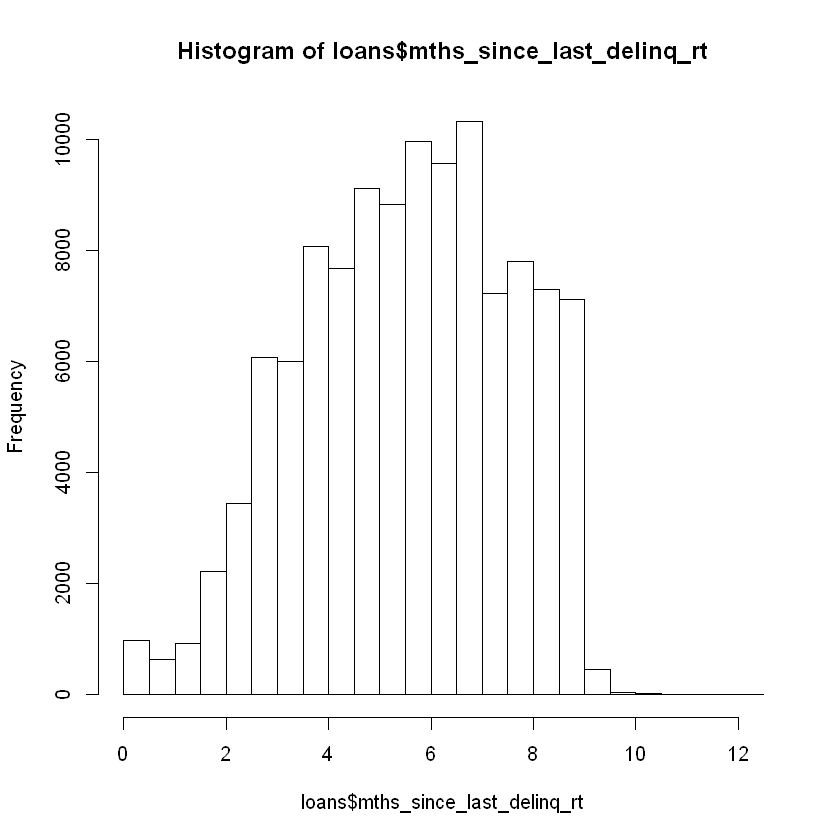

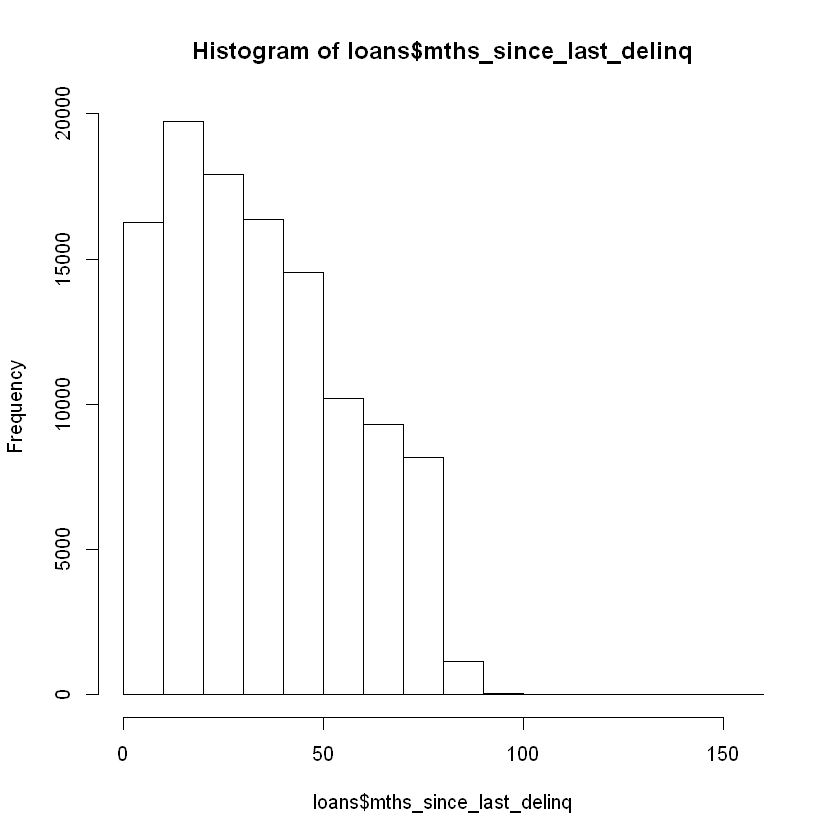

In [27]:
hist(loans$mths_since_last_delinq_rt)
hist(loans$mths_since_last_delinq)

### Continuous variables
<br> In this stage we looked at the continuous data.
<br> We will transform some of them by using log and square root transformations. 

 
<b>open_acc</b>
 <br>this variable has many different values and is distribution tends to the right .
<br>there for it is rational trying a square root transformation
  


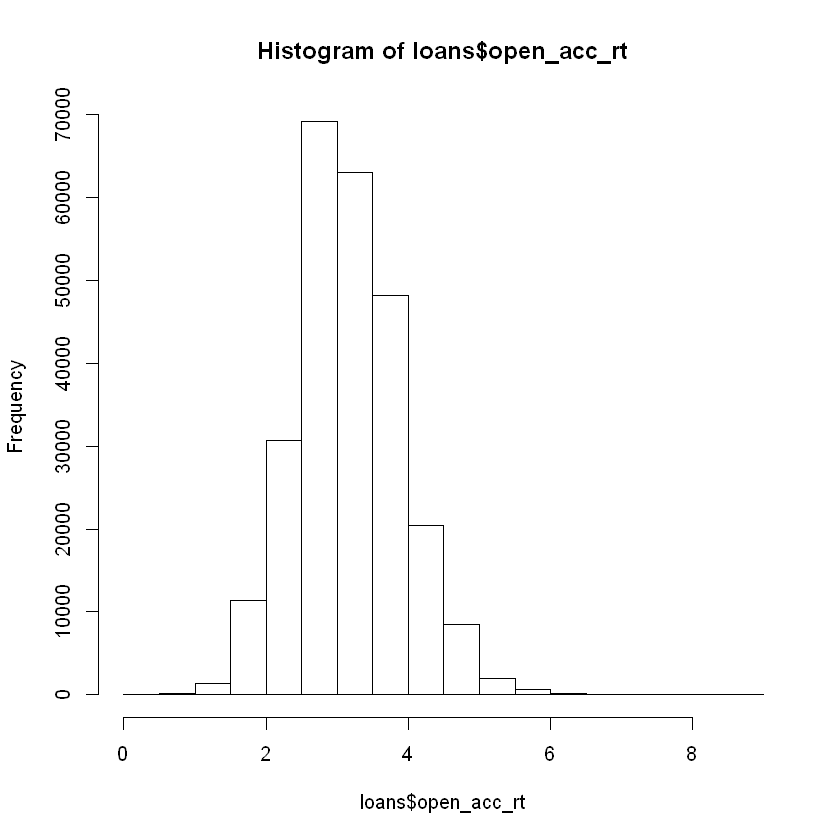

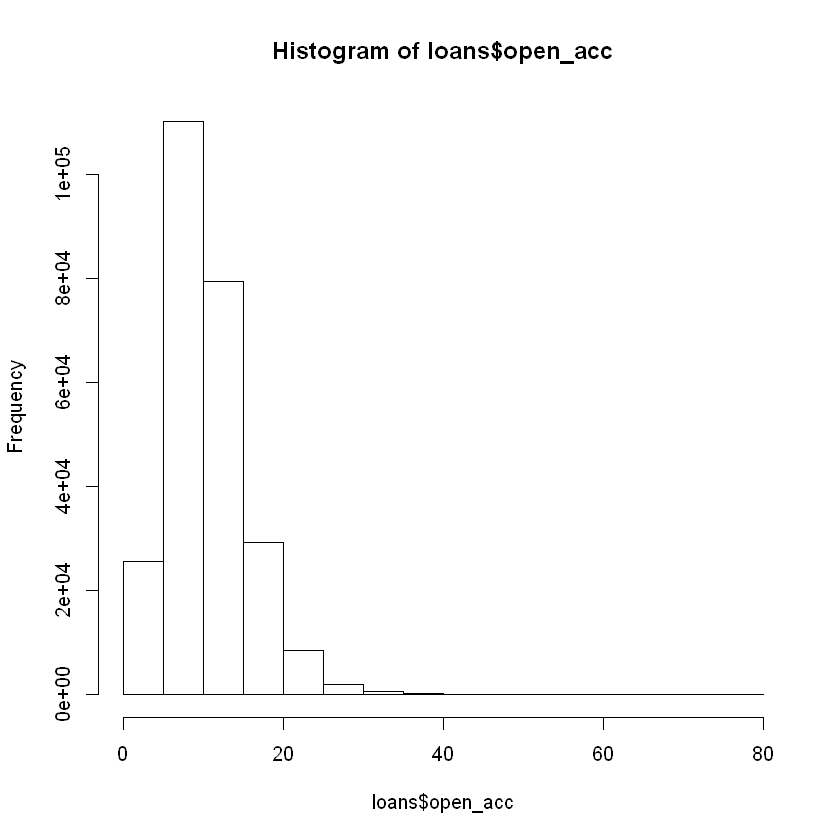

In [28]:
#trasform
loans$open_acc_rt<- loans$open_acc^0.5
hist(loans$open_acc_rt)
hist(loans$open_acc)


<b>total_acc</b>
this variable has many different values and is distribution tends to the right . 
there for it is rational trying a square root transformation
<br> like the open_acc variable

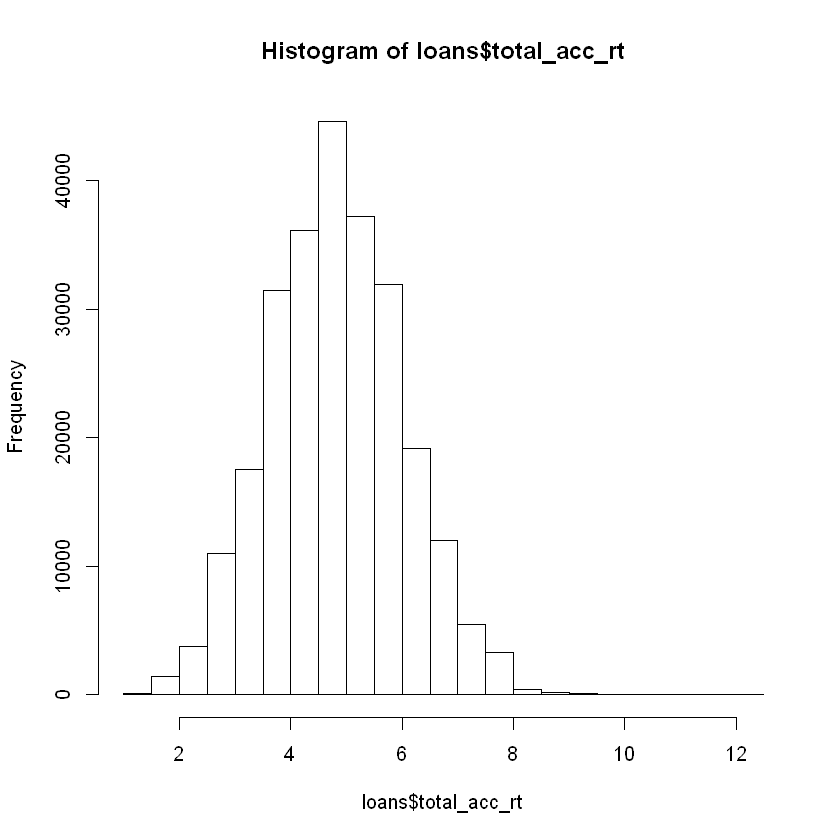

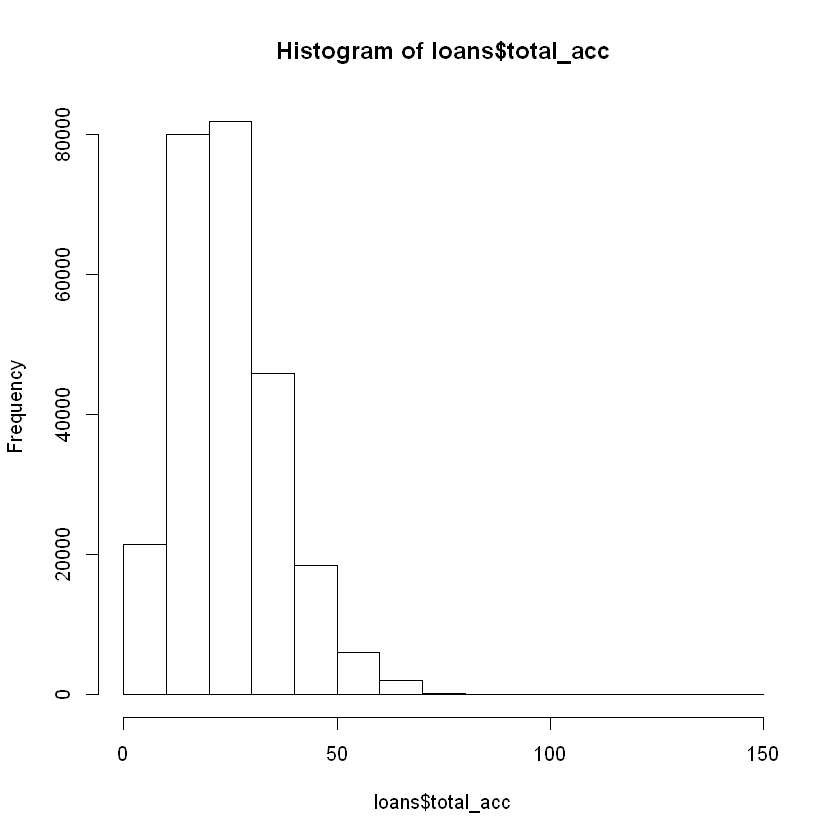

In [29]:
loans$total_acc_rt<- loans$total_acc^0.5
hist(loans$total_acc_rt)
hist(loans$total_acc)


<b>annual_inc</b>
<br> In the EDA stage we saw annual_inc have a very tend to the lowers values distribution
<br> we will make transformation with log and square root and also create a categorical variable with groupings of the income by quantiles

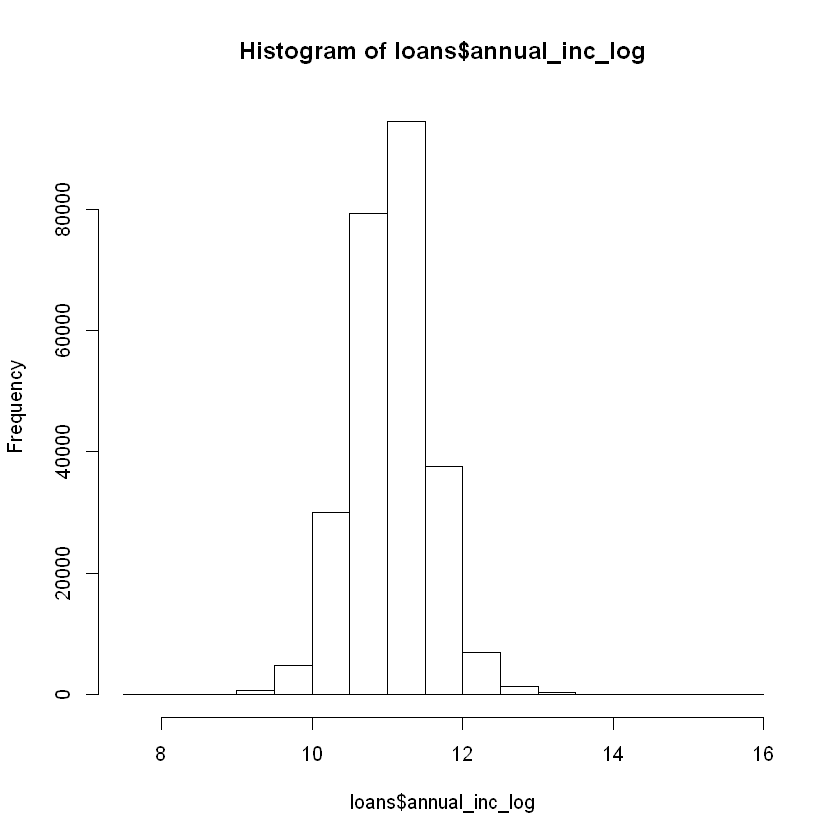

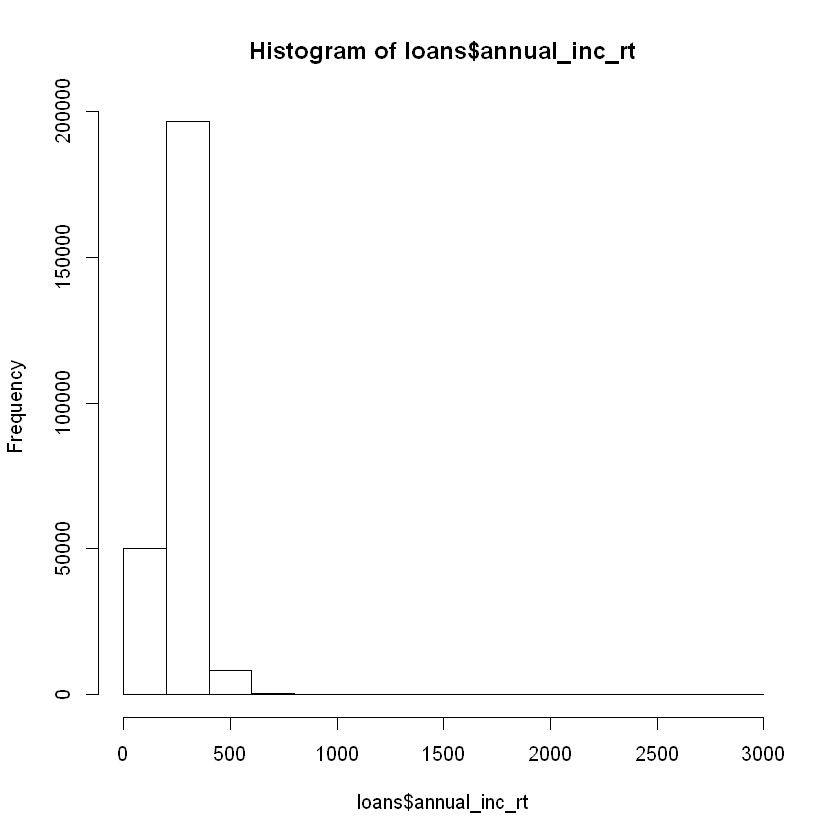

In [30]:
##transformations
loans$annual_inc_log<- log(loans$annual_inc)
loans$annual_inc_rt<-(loans$annual_inc)^0.5
hist(loans$annual_inc_log)
hist(loans$annual_inc_rt)



In [31]:
summary(loans$annual_inc)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1896   45000   62000   72526   87000 8706582       4 

In [32]:
## make a categorical
loans$inc_grp<-NULL
loans$inc_grp[loans$annual_inc <= 45000] <- "verylow_inc"
loans$inc_grp[loans$annual_inc > 45000 & loans$annual_inc <= 60000] <- 'low_inc'
loans$inc_grp[loans$annual_inc > 60000 & loans$annual_inc <= 87000] <- 'middle_inc'
loans$inc_grp[loans$annual_inc > 87000 & loans$annual_inc <= 120000] <- 'high_inc'
loans$inc_grp[loans$annual_inc > 120000] <- 'veryhigh_inc'


In [33]:
loans$inc_grp <-factor(loans$inc_grp)

<b>revol_bal</b>
<br>In the EDA stage we saw that revol_bal have a very tend to the lowers values distribution

In [34]:
loans$revol_bal_rt <-loans$revol_bal^0.5

In [ ]:
hist(loans$revol_bal)
hist(loans$revol_bal_rt)

<b>credit_hist</b>
<br> It seems that this variable has tend to the lowers values distribution.
<br> we will make transformation with log and square root and also create a categorical variable with groupings of the income by quantiles

In [36]:
## transformations
loans$credit_hist_log <-log(loans$credit_hist)
loans$credit_hist_rt <-loans$credit_hist^0.5

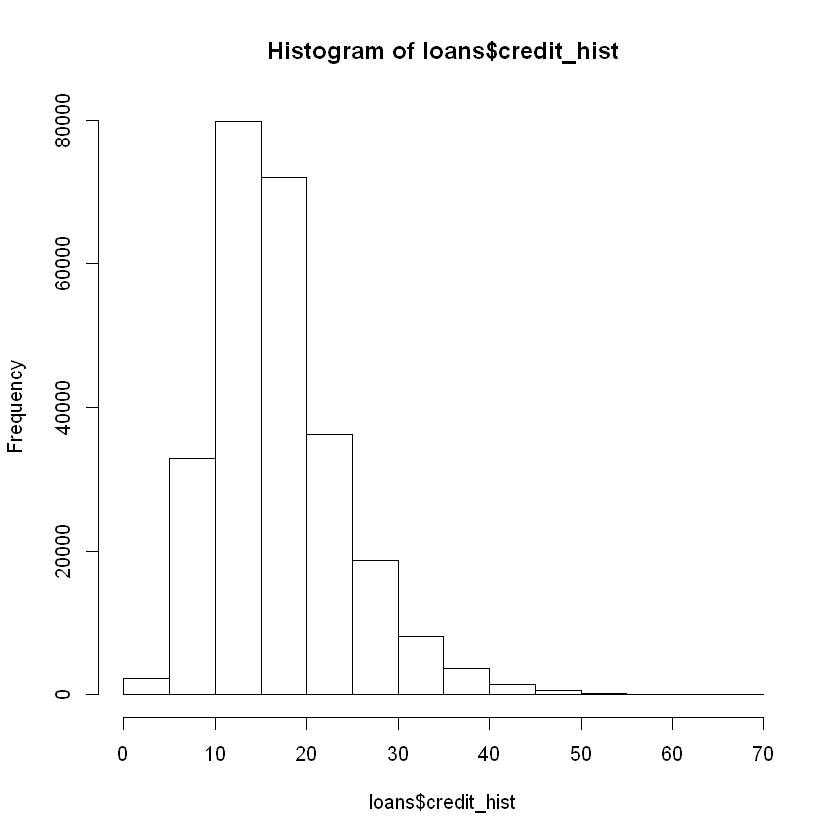

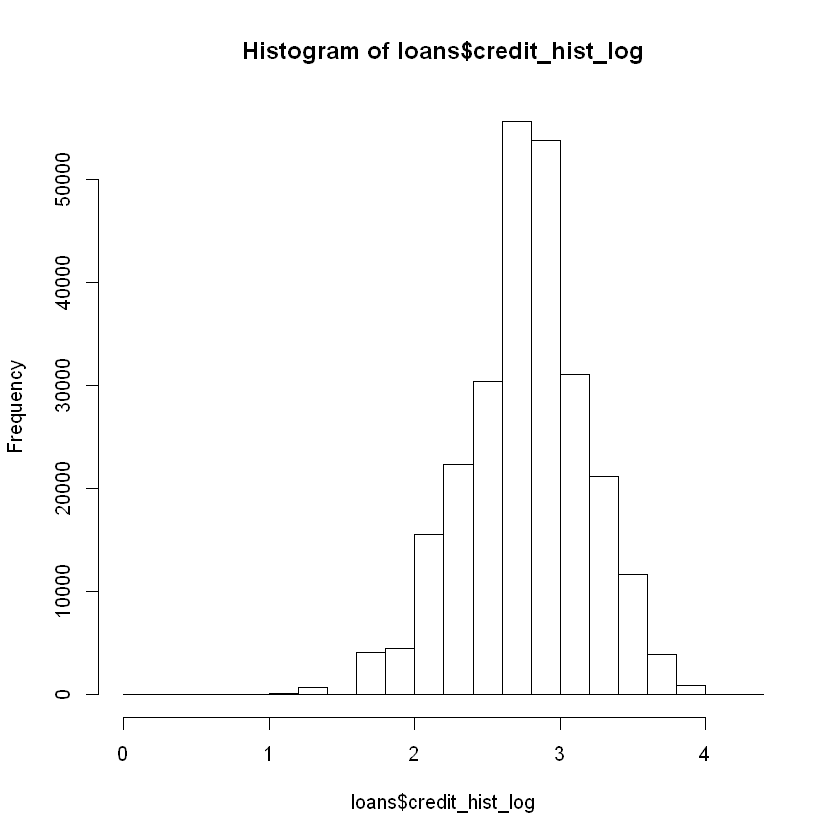

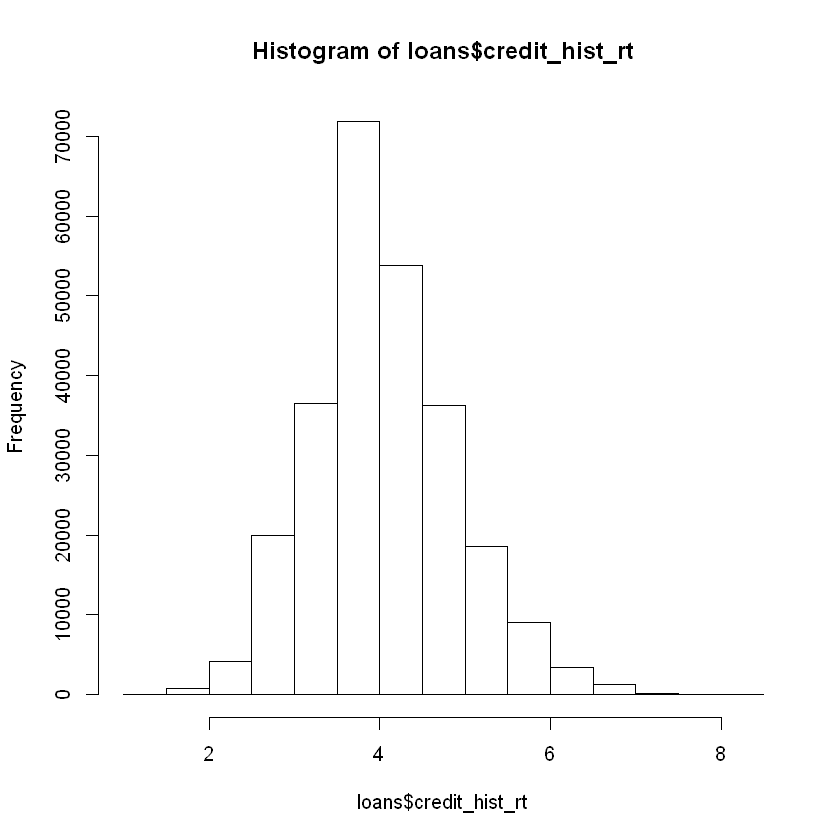

In [37]:
hist(loans$credit_hist)
hist(loans$credit_hist_log)
hist(loans$credit_hist_rt)

In [38]:
summary(loans$credit_hist)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   1.00   13.00   16.00   17.44   21.00   68.00      51 

In [39]:

loans$credit_hist_grp<-NULL
loans$credit_hist_grp[loans$credit_hist <= 4] <- '<4_yrs'
loans$credit_hist_grp[loans$credit_hist > 4 & loans$credit_hist <= 13] <- '4-13_yrs'
loans$credit_hist_grp[loans$credit_hist > 13 & loans$credit_hist <= 17] <- '13-17_yrs'
loans$credit_hist_grp[loans$credit_hist > 17 & loans$credit_hist <= 21] <- '17-21_yrs'
loans$credit_hist_grp[loans$credit_hist > 21] <- '>21_yrs'
loans$credit_hist_grp<-factor(loans$credit_hist_grp)


In [40]:
head(loans)

verification_status,issue_d,pymnt_plan,purpose,initial_list_status,emp_length,loan_amnt,funded_amnt,funded_amnt_inv,term,...,open_acc_rt,total_acc_rt,annual_inc_log,annual_inc_rt,inc_grp,revol_bal_log,revol_bal_rt,credit_hist_log,credit_hist_rt,credit_hist_grp
Not Verified,2007-10-01,0,debt_consolidation,1,2 years,10000,10000,2175.000,0,...,3.000000,4.472136,10.502324,190.7878,verylow_inc,9.123256,95.73923,2.397895,3.316625,4-13_yrs
Not Verified,2007-12-01,0,credit_card,1,1 year,5400,5400,375.000,0,...,3.316625,3.464102,10.645425,204.9390,verylow_inc,10.546761,195.07434,2.079442,2.828427,4-13_yrs
Not Verified,2007-11-01,0,debt_consolidation,1,2 years,1500,1500,583.050,0,...,2.000000,2.000000,9.655026,124.9000,verylow_inc,8.750208,79.44810,1.945910,2.645751,4-13_yrs
Not Verified,2007-12-01,0,home_improvement,1,6 years,4800,4800,1550.000,0,...,3.464102,4.898979,11.002100,244.9490,low_inc,7.945201,53.12250,2.397895,3.316625,4-13_yrs
Not Verified,2007-10-01,0,debt_consolidation,1,< 1 year,4800,4800,1625.000,0,...,2.236068,4.123106,10.126631,158.1139,verylow_inc,6.013715,20.22375,2.302585,3.162278,4-13_yrs
Not Verified,2007-10-01,0,other,1,1 year,4200,4200,1125.002,0,...,1.414214,1.732051,10.085809,154.9193,verylow_inc,-Inf,0.00000,2.708050,3.872983,13-17_yrs


In [1]:
dim(loans)

ERROR: Error in eval(expr, envir, enclos): object 'loans' not found


We created 14 new variables by using transformations and grouping to categories.
We hope those variables will help us to create a better predictive model.

In [42]:
##SQLLite Converts the date to numeric so imlilictly apply as.character on date columns
loans$issue_d <- as.character(loans$issue_d)

In [ ]:
writeSQL(loans,"loans_dataset_eng")

Add the new variables to Data Retrieval Protocol.xlsx

In [7]:
summary(loans)

 verification_status   issue_d           pymnt_plan          purpose         
 Length:255720       Length:255720      Length:255720      Length:255720     
 Class :character    Class :character   Class :character   Class :character  
 Mode  :character    Mode  :character   Mode  :character   Mode  :character  
                                                                             
                                                                             
                                                                             
                                                                             
 initial_list_status  emp_length          loan_amnt      funded_amnt   
 Length:255720       Length:255720      Min.   :  500   Min.   :  500  
 Class :character    Class :character   1st Qu.: 7200   1st Qu.: 7200  
 Mode  :character    Mode  :character   Median :12000   Median :12000  
                                        Mean   :13514   Mean   :13472  
                

In [8]:
meta_loans <- funModeling::df_status(loans, print_results = FALSE)
meta_loans%>%
  knitr::kable()



|variable                       | q_zeros| p_zeros|   q_na|  p_na| q_inf| p_inf|type      | unique|
|:------------------------------|-------:|-------:|------:|-----:|-----:|-----:|:---------|------:|
|verification_status            |       0|    0.00|      0|  0.00|     0|     0|character |      3|
|issue_d                        |       0|    0.00|      0|  0.00|     0|     0|character |    103|
|pymnt_plan                     |  255718|  100.00|      0|  0.00|     0|     0|character |      2|
|purpose                        |       0|    0.00|      0|  0.00|     0|     0|character |     14|
|initial_list_status            |   70892|   27.72|      0|  0.00|     0|     0|character |      2|
|emp_length                     |       0|    0.00|      0|  0.00|     0|     0|character |     12|
|loan_amnt                      |       0|    0.00|      0|  0.00|     0|     0|integer   |   1331|
|funded_amnt                    |       0|    0.00|      0|  0.00|     0|     0|integer   |   1331